In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta

sns.set_theme(style="whitegrid", context='talk', palette='Greys')

## Correlation analysis

In [34]:
data = pd.read_csv("data/bias_symptoms_raw.csv", index_col=[0, 1])

In [35]:
data.drop(columns=["neg_prob", "priv_prob_neg", "unpriv_prob_neg"], inplace=True)

In [36]:
data

,,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,pos_prob,kurtosis_var,skew_var
variable,data,,,,,,,,,,,,
race,adult,0.084531,0.004036,0.129252,0.252500,0.536785,1.048638,-0.167058,-0.055782,-0.221519,0.123248,5.639858,-2.763370
sex,adult,0.230065,0.029482,0.101744,0.310378,0.422546,1.289007,-0.157207,-0.127140,-0.058324,0.208634,-1.501940,-0.706421
10th,adult,-0.079627,0.004225,0.246914,0.051546,1.025437,0.214073,0.191191,0.118290,0.309504,0.195367,26.974784,5.381203
11th,adult,-0.091252,0.005677,0.248489,0.043103,1.031979,0.179009,0.192411,0.127817,0.309825,0.205385,21.748435,4.871794
12th,adult,-0.051403,0.001712,0.243518,0.063830,1.011336,0.265086,0.144844,0.060667,0.284822,0.179688,60.945596,7.931343
...,...,...,...,...,...,...,...,...,...,...,...,...,...
type,wine,0.085865,0.005864,0.384615,0.476510,0.852241,1.055864,-0.159525,0.014760,-0.149652,0.091895,-0.975126,-1.013928
alcohol,wine,0.363793,0.081020,0.404580,0.497175,0.883764,1.086028,-0.640531,-0.015267,-0.626511,0.092595,-1.914522,-0.302827
type,wine,0.142046,0.013685,0.416667,0.469008,0.910165,1.024500,-0.235537,-0.039945,-0.233977,0.052342,-0.051297,-1.396023


In [37]:
data.shape

(5930, 12)

In [38]:
sp = data.pop('statistical_parity')
eo = data.pop('equal_opportunity')
ao = data.pop('average_odds')

data.insert(len(data.columns), 'statistical_parity', sp)
data.insert(len(data.columns), 'equal_opportunity', eo)
data.insert(len(data.columns), 'average_odds', ao)

In [41]:
kendall = data.corr("kendall").round(3)
for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if np.abs(kendall.loc[col, col2]) > 0.3:
            kendall.loc[col, col2] = r"\cellcolor{black!25}\textbf{" + str(kendall.loc[col, col2]) + "}"
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

C:\Users\giord\AppData\Local\Temp\ipykernel_26500\2030087497.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\cellcolor{black!25}\textbf{1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kendall.loc[col, col2] = r"\cellcolor{black!25}\textbf{" + str(kendall.loc[col, col2]) + "}"
C:\Users\giord\AppData\Local\Temp\ipykernel_26500\2030087497.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.015*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"
C:\Users\giord\AppData\Local\Temp\ipykernel_26500\2030087497.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002*' has dtype incompatible with floa

In [42]:
kendall.to_latex('full_corr.tex', float_format="%.3f", escape=False)

## Distribution of the data

In [31]:
data = pd.read_csv("data/bias_symptoms.csv", index_col=[0, 1])

In [32]:
data.drop(columns=["neg_prob", "priv_prob_neg", "unpriv_prob_neg"], inplace=True)

In [33]:
data.to_csv("data/bias_symptoms.csv")

In [11]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

TtestResult(statistic=12.181259491235245, pvalue=1.1050329735503381e-33, df=5273.542215517817)
TtestResult(statistic=4.786364614393508, pvalue=1.7416530854575574e-06, df=5636.609250654234)
TtestResult(statistic=9.020402611410422, pvalue=2.5532467484102347e-19, df=5428.3964856789435)
(0.24800113804483898, 'small')
(0.14345199201317407, 'negligible')
(0.16380084964387895, 'small')


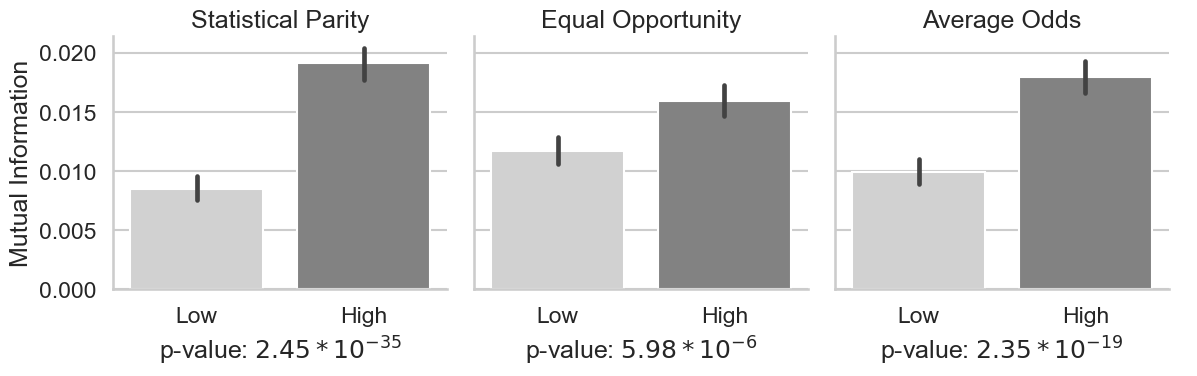

In [12]:
g = plot_differences(data, "mutual_info", "Mutual Information")
g.facet_axis(0, 0).set_xlabel(
    "p-value: $2.45*10^{-35}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 1).set_xlabel(
    "p-value: $5.98*10^{-6}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: $2.35*10^{-19}$", labelpad=5, fontdict={"fontsize": 18}
)
plt.savefig("figs/Mutual Information.pdf", bbox_inches="tight")
plt.show()

## Kendall's Tau

TtestResult(statistic=4.920407206060938, pvalue=8.90281128912713e-07, df=5200.347519522351)
TtestResult(statistic=1.0408287481716432, pvalue=0.2979981167681029, df=5840.691785936164)
TtestResult(statistic=2.3224218686699163, pvalue=0.020247882182147535, df=5305.203909487781)
(0.07416638215545693, 'negligible')
(-0.0189713316328065, 'negligible')
(0.02966817894196853, 'negligible')


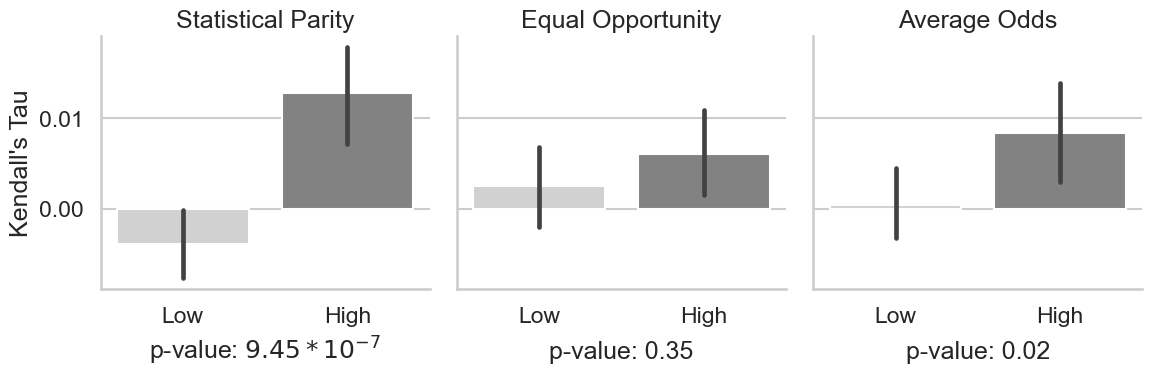

In [13]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")

g.facet_axis(0,0).set_xlabel("p-value: $9.45*10^{-7}$", labelpad=5, fontdict={'fontsize': 18})
g.facet_axis(0, 1).set_xlabel(
    "p-value: 0.35", labelpad=10, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: 0.02", labelpad=10, fontdict={"fontsize": 18}
)
plt.savefig("figs/Kendall's Tau.pdf", bbox_inches="tight")
plt.show()

## Metrics Distribution

In [14]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [15]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Percentage')

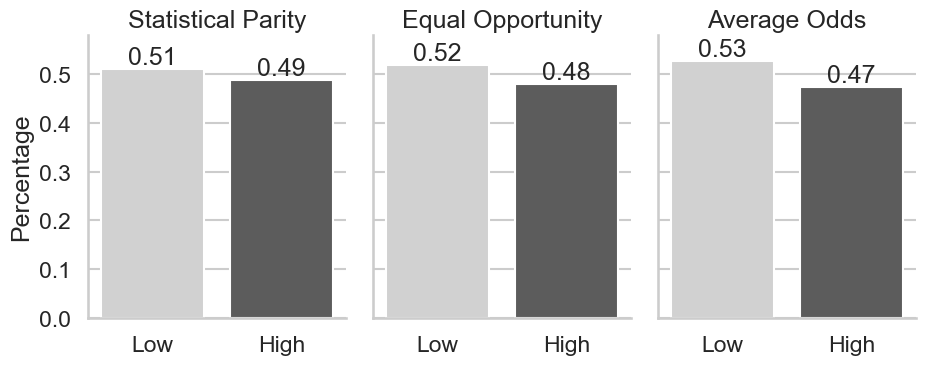

In [16]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Percentage",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[1:5:3],
    height=4,
    aspect=0.8,
)


for i in range(3):
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[0], fmt="%.2f")
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[1], fmt="%.2f")

g.set_titles("{col_name}")
# plt.subplots_adjust(top=1.3)
g.set_axis_labels("")
plt.ylim(0,0.58)
plt.tight_layout()
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()

## Distribution of SP, EO and AO

In [17]:
raw = pd.read_csv("data/bias_symptoms_raw.csv", index_col=[0, 1])
metrics = raw[['statistical_parity', 'equal_opportunity', 'average_odds']]
metrics = pd.melt(metrics, var_name='Metric', value_name='Value')
metrics['Metric'] = metrics['Metric'].map({'statistical_parity': 'Statistical Parity', 'equal_opportunity': 'Equal Opportunity', 'average_odds': 'Average Odds'})
metrics['Value'] = metrics['Value'].abs()

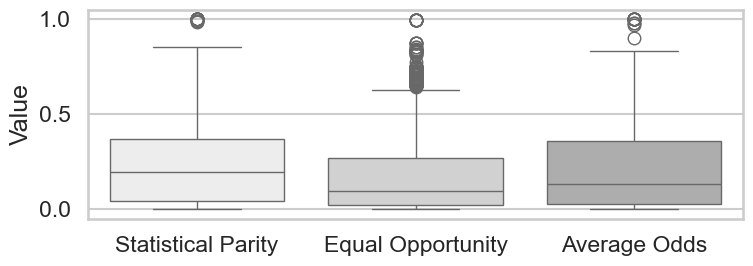

In [18]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=metrics, x='Metric', y='Value', hue='Metric')
plt.xlabel('')
plt.tight_layout()
plt.savefig('figs/metrics_boxplot.pdf', bbox_inches='tight')
plt.show()